
# Semestral Work Assignment (4IZ172) – Clustering


# Imports

## Libraries

In [226]:
# pandas -> we are working with dataframes
import pandas as pd
import numpy as np

# chardet -> used for the detection of the encoding of the csv file
import chardet

# sklearn -> the library of choice for machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# scipy
import scipy.cluster.hierarchy as sch

# re -> for regular expressions to clean text
import re

# nltk -> natural language tool kit, the library we will use for NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# inflect ->
import inflect

# matplotlib and seaborn -> for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [227]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brzak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\brzak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brzak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True


## Dataset
For this coursework i chose the FIS bachelor's thesis dataset.

Not all datasets to choose from for this coursework are encoded the same, so let's look at this one in particular.

In [228]:
path = "data/RawDatasetFISbachelor.csv"
with open(path, 'rb') as f:
    rawdata = f.read()
result = chardet.detect(rawdata)
encoding = result['encoding']
print(f"Detected encoding: {encoding}")

Detected encoding: UTF-8-SIG


By having a quick look at the file, we see it is a normal utf-8 csv, let's load it!

In [229]:
# We have the encoding, now we can read the CSV file
df_fis = pd.read_csv("data/RawDatasetFISbachelor.csv", sep=";")

### Dataset statistics

In [230]:
na_count = df_fis.isna().any(axis=1).sum()
print(na_count)

0


None of the rows contain any NA values, which is a nice start.

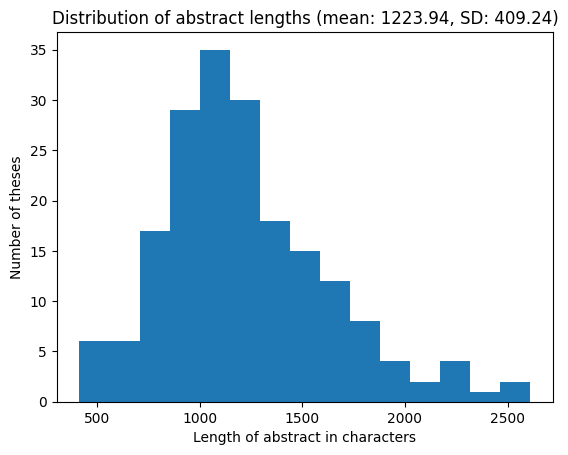

In [231]:
abstract_lens = df_fis["AbstractEN"].apply(len)
avg_abstract_len = round(abstract_lens.mean(),2)
std_abstract_len = round(np.sqrt(abstract_lens.var()),2)
plt.hist(abstract_lens, bins = 15)
plt.xlabel("Length of abstract in characters")
plt.ylabel("Number of theses")
plt.title(f"Distribution of abstract lengths (mean: {avg_abstract_len}, SD: {std_abstract_len})")
plt.show()


# Preprocessing
The section should contain:

Description of preprocessing steps involved
Report on the preprocessing results


In [232]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    
    # Stem each token
    lemmatized_tokens = [stemmer.stem(token) for token in tokens]

    # Join the tokens back into a string
    return " ".join(lemmatized_tokens)


df_fis['EN_preprocessed'] = df_fis['AbstractEN'].apply(preprocess)
for i in range(5):
    print(df_fis['EN_preprocessed'].iloc[i])

    
df_fis = df_fis.drop(labels=[10, 36, 43, 44, 50, 61, 106, 113, 135, 139, 141, 143, 158, 174, 184], axis=0)

the present bachelor thesi focus on a detail analysi of data architectur , process , and role in a select small or medium-s enterpris . the aim is to identifi key area for improv the effici and competit of the enterpris . thi thesi will provid the enterpris with a set of suggest for improv . the propos will focu on data govern , modern data architectur , new role , and process . the research method includ a literatur search and a semi-structur interview with a select data profession oper in the select compani . base on the analysi of the statu , specif improv and measur will be propos . these suggest will then be valid with expert and practition in the field to verifi their relev and feasibl .
the thesi is centr around design and implement an e-shop which sell custom made paint . along with that the site will serv as an onlin present for the artist bc . kateřina beránková , whose art piec are display there . for the develop i use the mmsp methodolog , thank to which i wa abl to custom 

While preprocessing, we apply stemming to reduce the dictionary of the documents. In closer analysis we can see, that several theses are not actually translated into english. I have decided to remove these to not distort the dictionary further.

### TF-IDF matrix

In [233]:
documents = df_fis["AbstractEN"].tolist()
names = df_fis["titleEN"].tolist()
supervisors = df_fis["Supervisor"].tolist()
tfidfvectorizer = TfidfVectorizer(stop_words='english')
countvectorizer = TfidfVectorizer(stop_words='english', use_idf=False, norm=None)

tfidf = tfidfvectorizer.fit_transform(raw_documents=documents)
tfidf_df = pd.DataFrame(tfidf.todense(), index=names, columns=tfidfvectorizer.get_feature_names_out())

absolute_tfidf = countvectorizer.fit_transform(raw_documents=documents)
absolute_tfidf_df = pd.DataFrame(absolute_tfidf.todense(), index=names, columns=countvectorizer.get_feature_names_out())

similarity_matrix = cosine_similarity(tfidf)
tfidf_df # type: ignore

,03bb,100,14,183,19,19510,1995,20,2013,2014,...,yielded,young,younger,youth,youtube,zabbix,zones,zuykina,červený,čsob
"Analysis of data architecture, processes and roles of a selected enterprise",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
E-shop for selling custom artwork,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Fake news and manipulation on social networks,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.196285,0.0,0.0,0.0,0.0,0.0,0.112379,0.0,0.0
Migrating on-premise web application to the cloud,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Mobile application for monitoring and improving sleep habits,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Flask homework app,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Application portfolio for event management support,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AI-powered competitive website search system,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
Development of a Library Set for Teaching the Fundamentals of Object-Oriented Architecture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


We create a DTM using TFIDF weighting. Just out of curiosity, I also created a DTM with simple absolute weighting.

### PCA

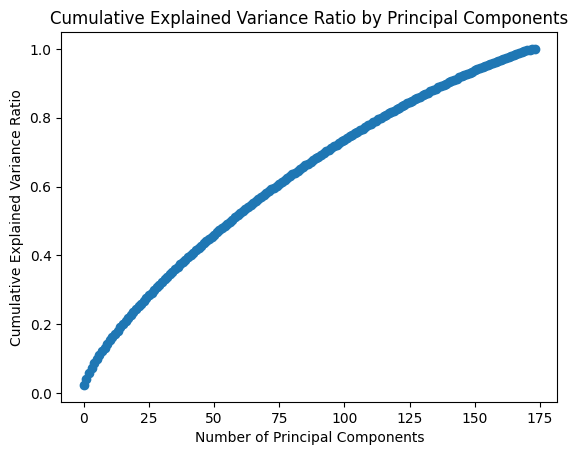

In [234]:
pca_tuning = PCA()
X_pca_tuning = pca_tuning.fit_transform(tfidf_df)

explained_variance = pca_tuning.explained_variance_
total_explained_variance = explained_variance.sum()

explained_variance_ratio = pca_tuning.explained_variance_ratio_
total_explained_variance_ratio = explained_variance_ratio.sum()

cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')
plt.show()


Let's look at the variance reduction ratio plotted against the hyperparameter n of PCA (number of components used in encoding). We can see the curve only rises very slowly, this is caused by high dimensionality of our data (there are 2080 words in the dictionary, or 2080 columns in the DTM matrix). 

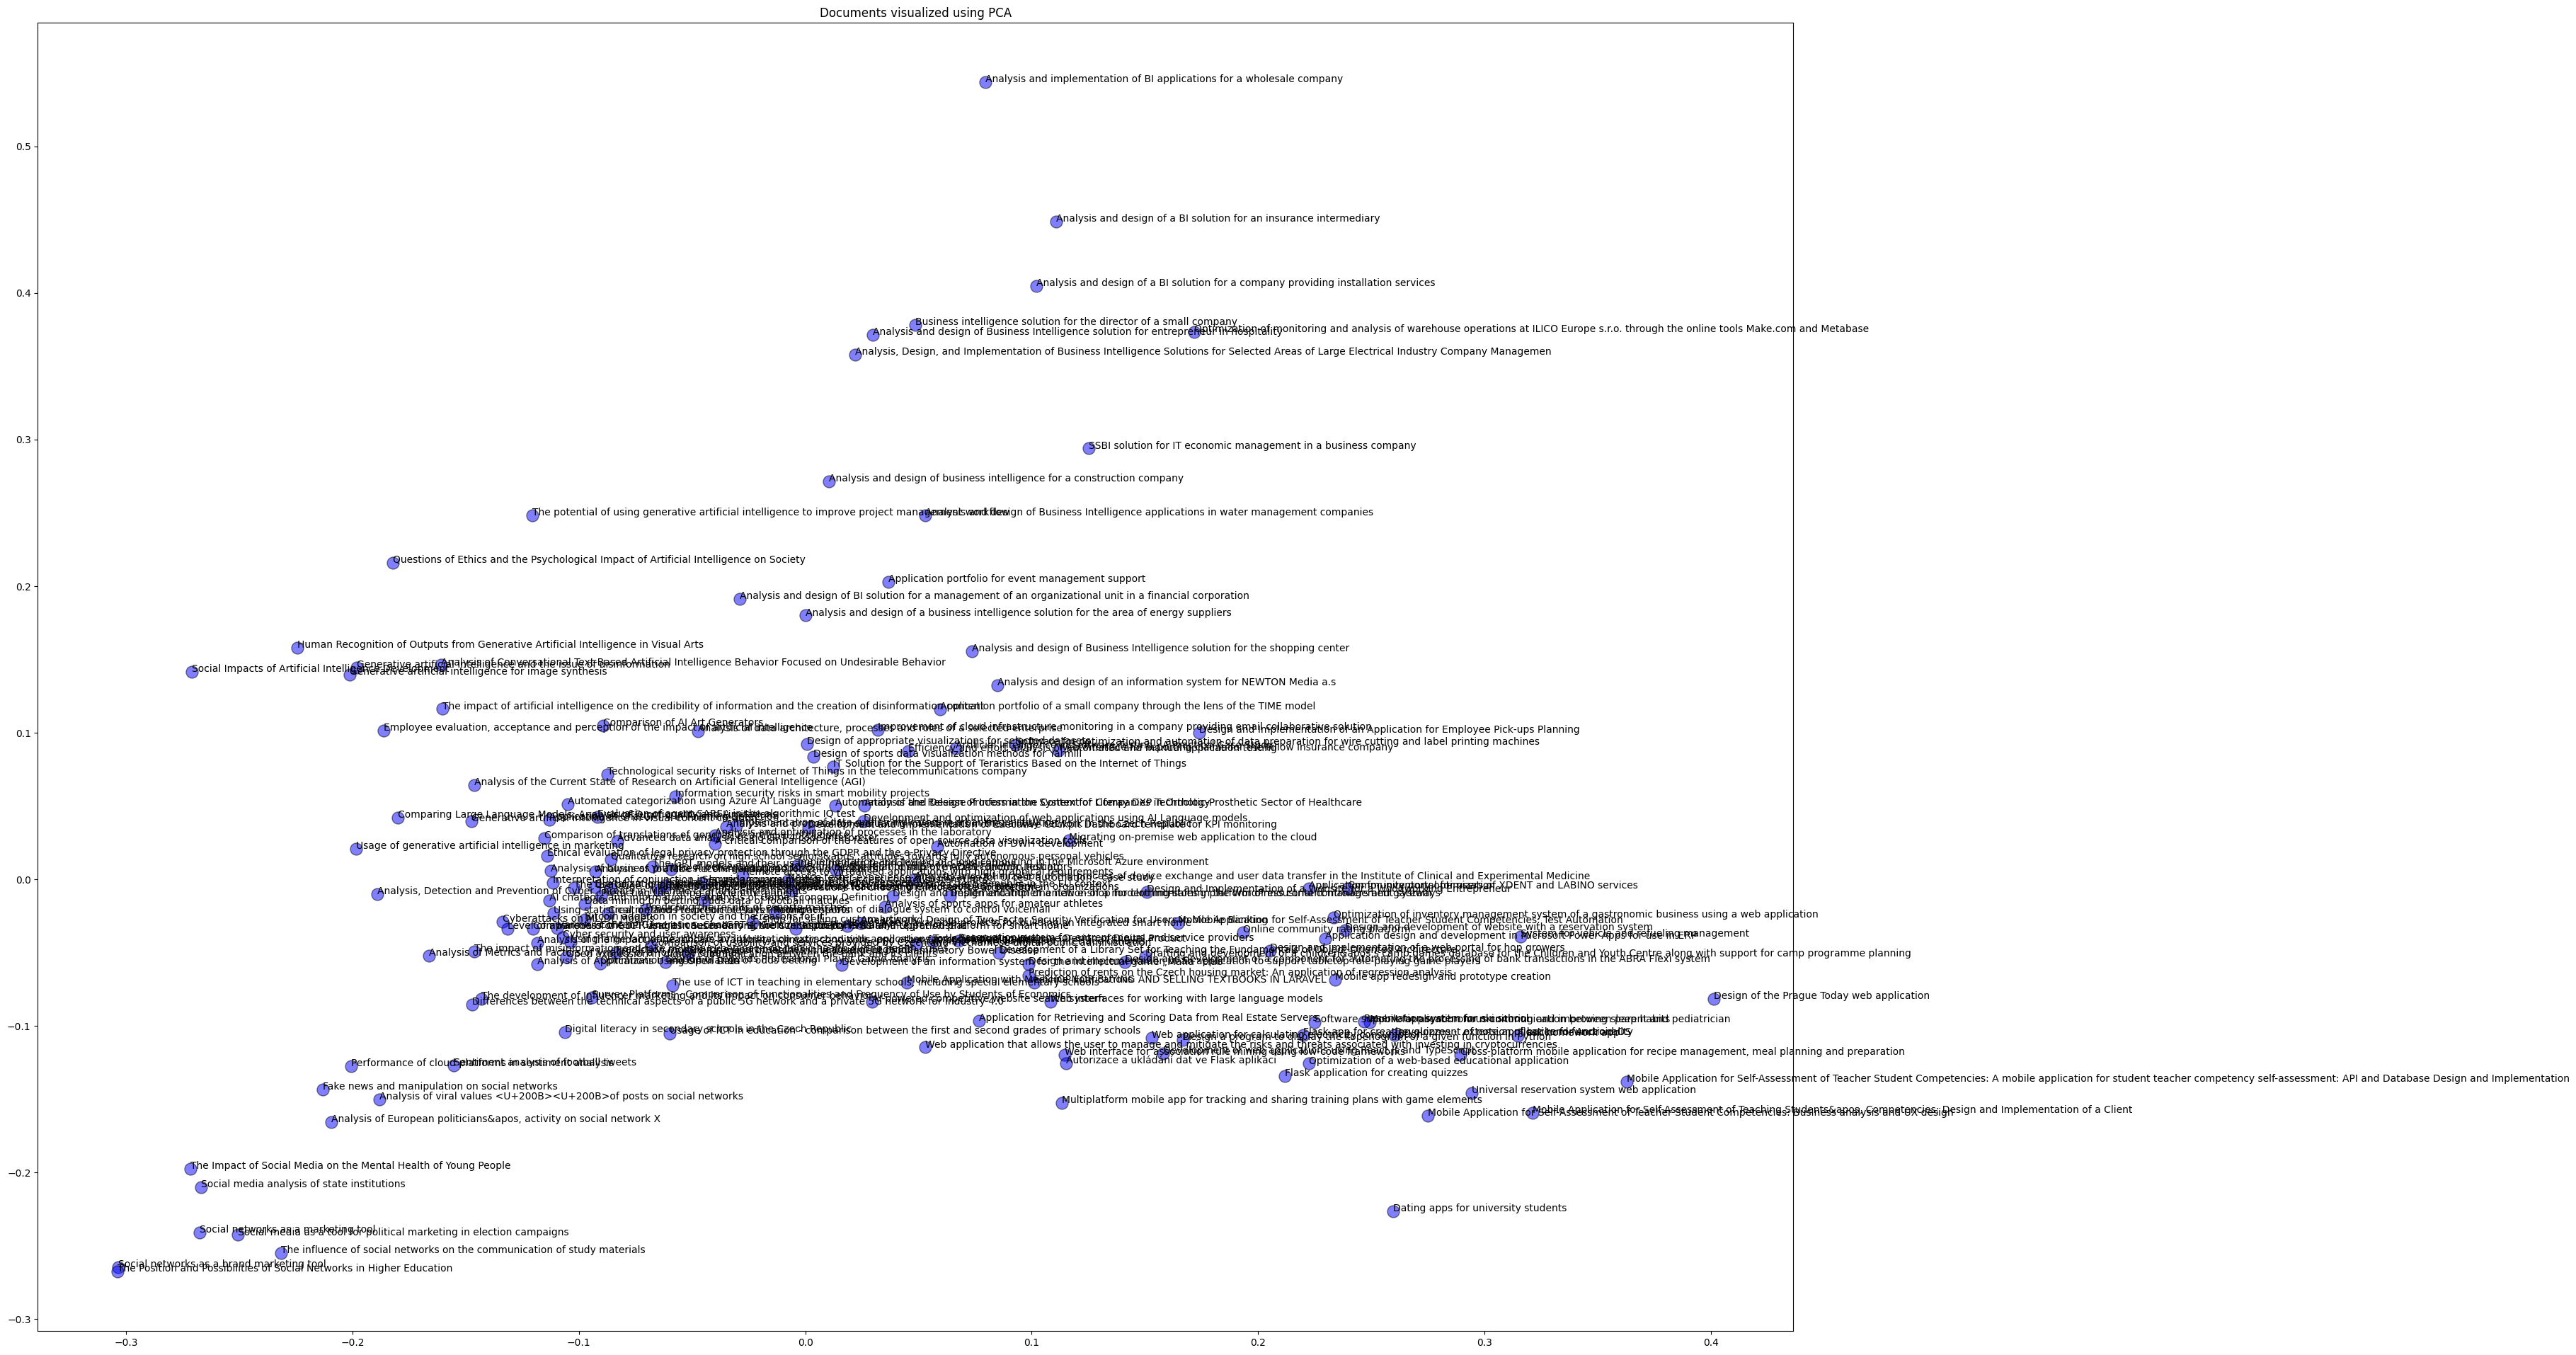

In [235]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(tfidf_df)

plt.figure(figsize=(32, 24))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c='blue', edgecolors='k', s=150, alpha=0.5)
for i, filename in enumerate(names):
    plt.annotate(filename, (reduced_data[i, 0], reduced_data[i, 1]))
plt.title("Documents visualized using PCA")
plt.show()

### t-SNE

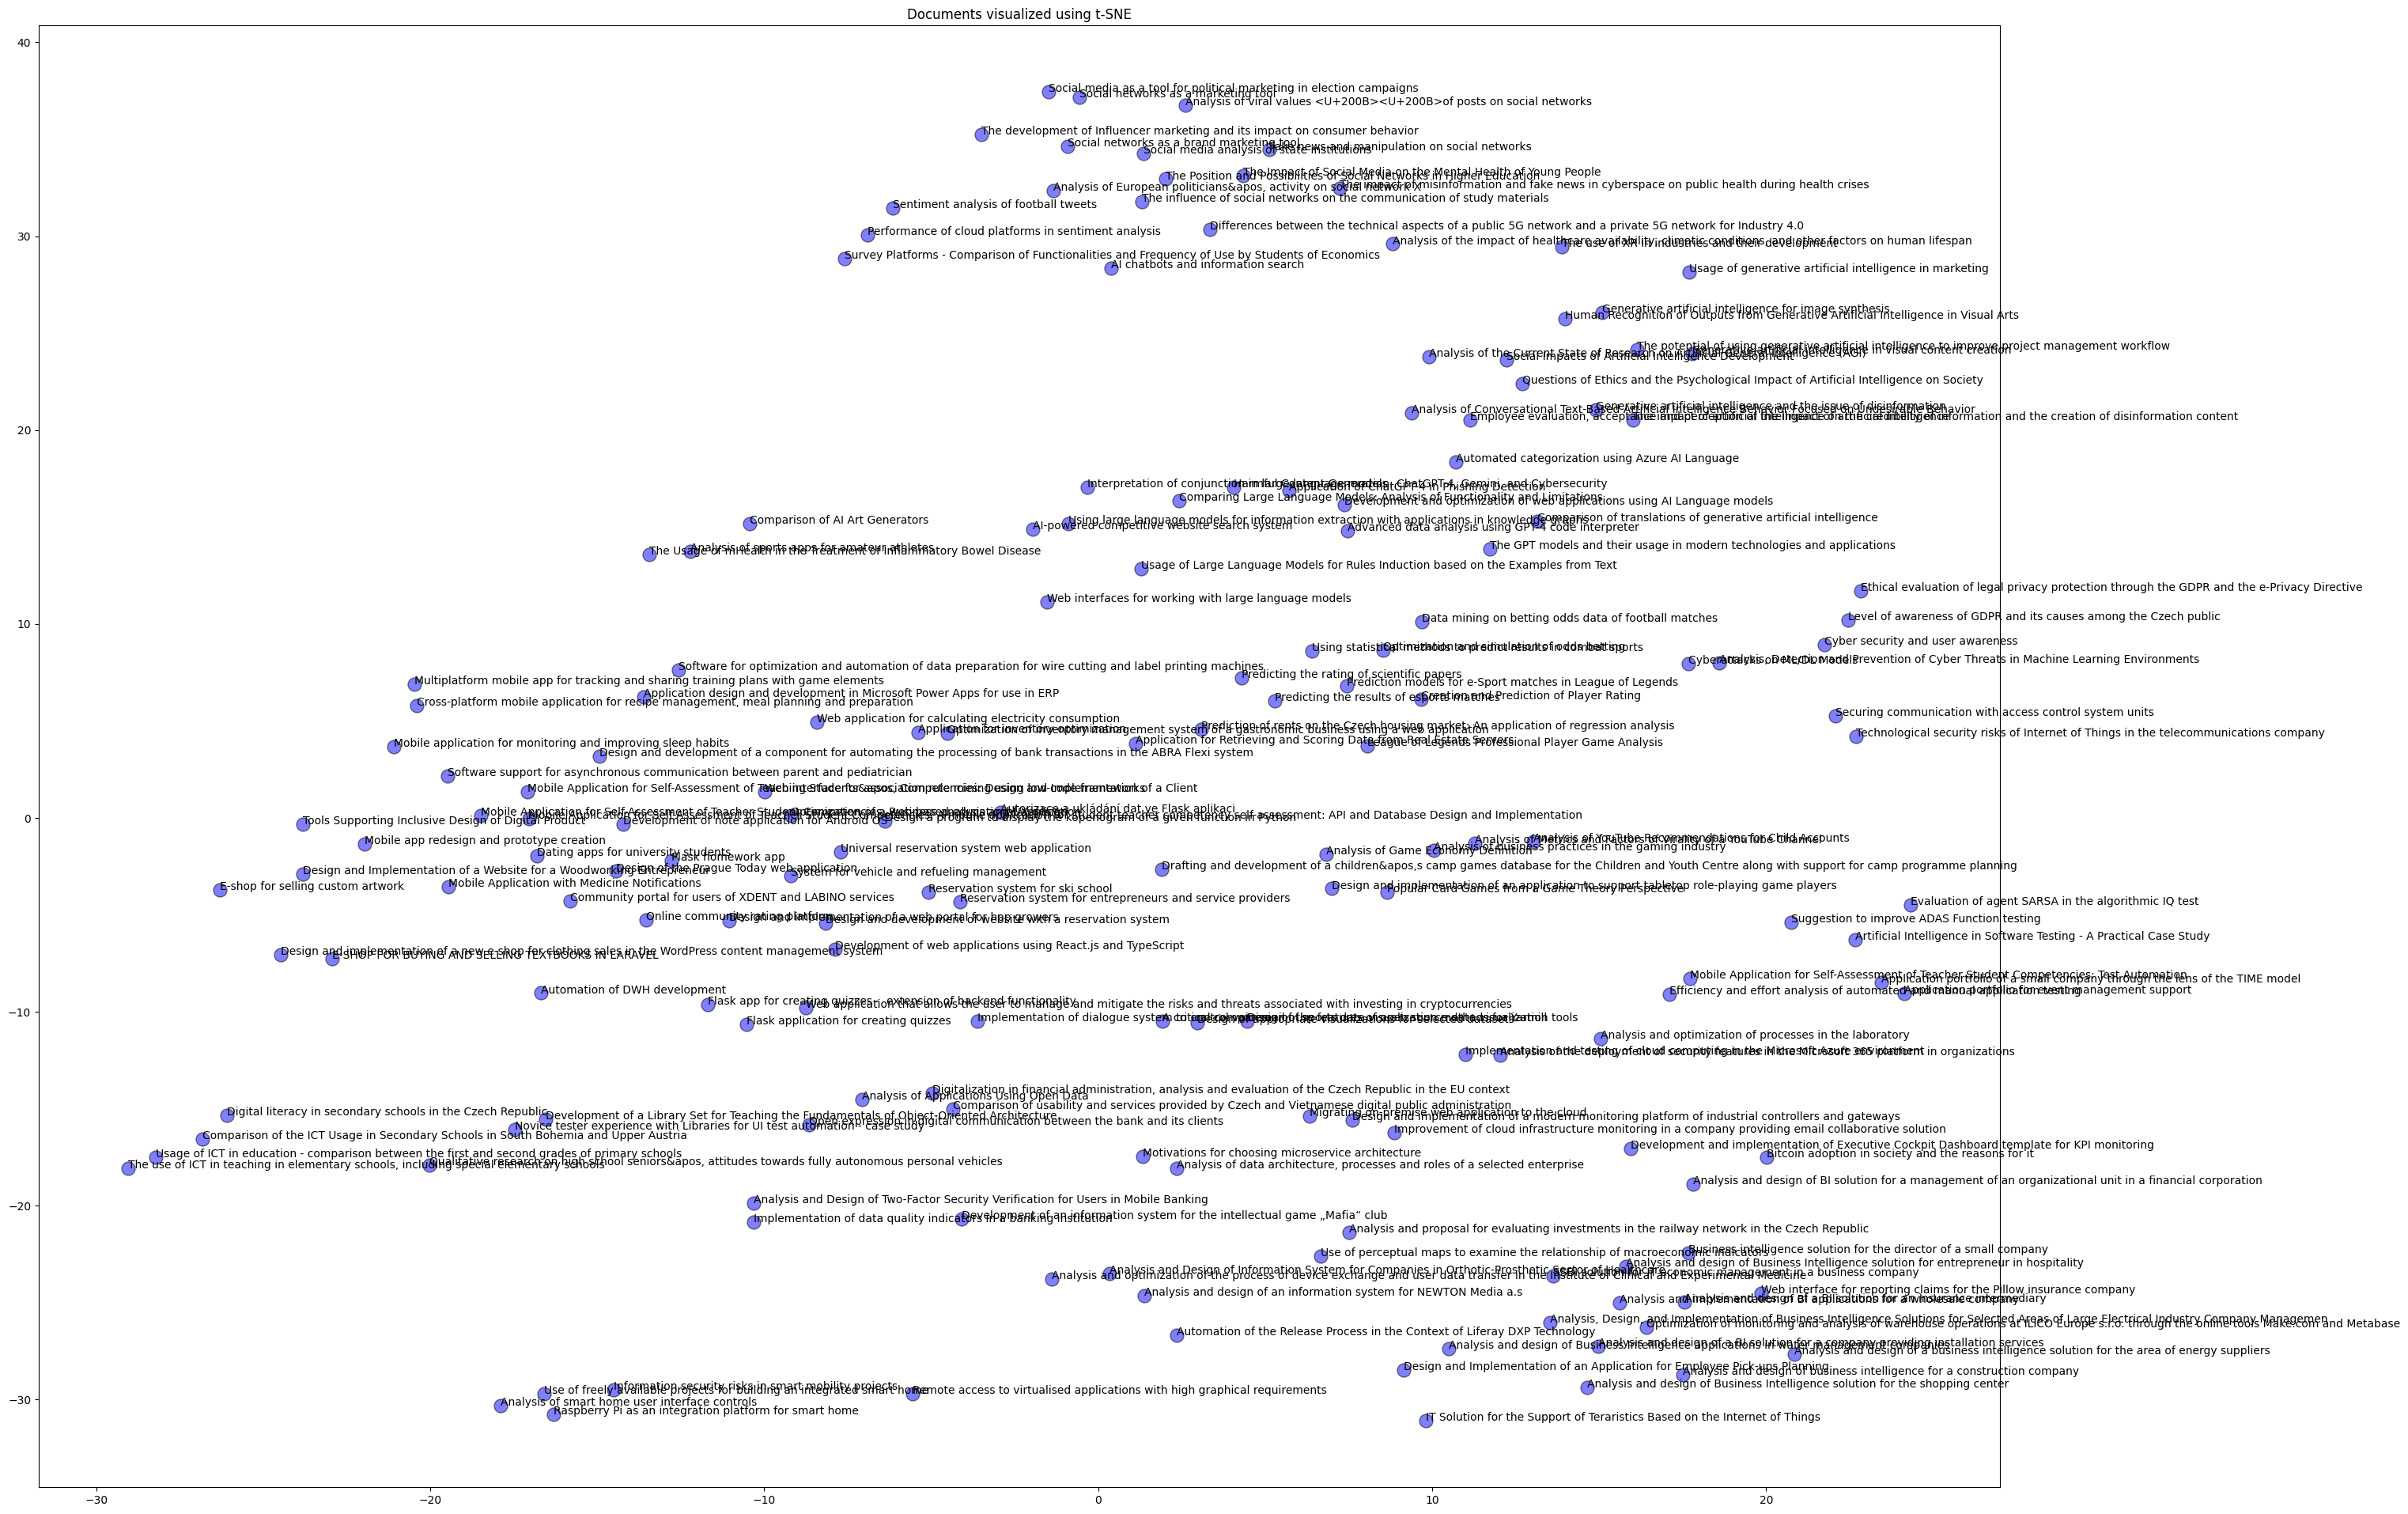

In [236]:
# Plot tSNE embeddings function
def plot_tsne(similarity_matrix, filenames):
    perplexity = min(10, len(filenames) - 1)  # Perplexity must be lower than the number of items
    distance_matrix = 1 - similarity_matrix
    distance_matrix[distance_matrix < 0] = 0  # We do not want to have negative values
    tsne = TSNE(n_components=2, metric="precomputed", perplexity=perplexity, init="random", random_state=42)
    embedding = tsne.fit_transform(distance_matrix)

    plt.figure(figsize=(32, 24))
    plt.scatter(embedding[:, 0], embedding[:, 1], c='blue', edgecolors='k', s=150, alpha=0.5)
    for i, filename in enumerate(filenames):
        plt.annotate(filename, (embedding[i, 0], embedding[i, 1]))
    plt.title("Documents visualized using t-SNE")
    plt.show()
    
plot_tsne(similarity_matrix, names)

In addition to PCA, let's also look at t-SNE. This method focuses on preserving local relationships between individual documents in contrast with PCA.


# Clustering + visualisation
This section should contain:

List of clustering methods considered
Estimation of the number of clusters (methods, results, discussion)
Comparison of (the results of) clustering methods on the selected dataset


## Hierarchical clustering

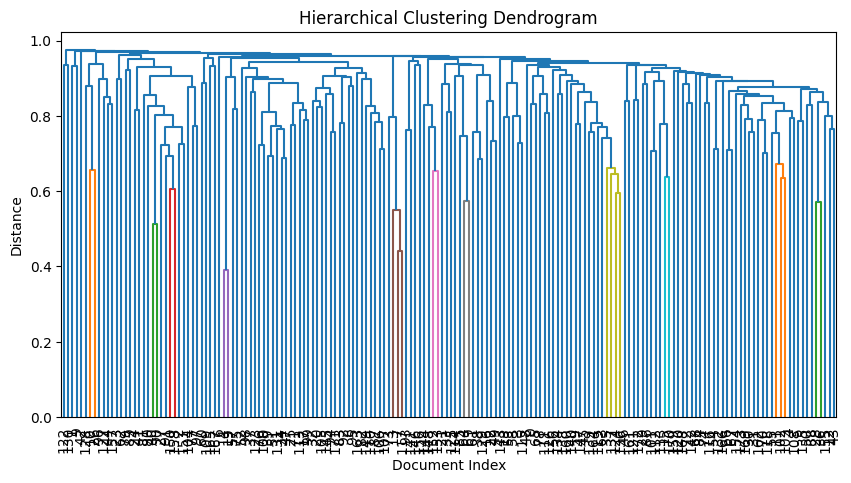

In [237]:
def plot_dendrogram(dtm_df:pd.DataFrame):
    
    # Perform the first part -- hierarchical clustering
    linkage_matrix = sch.linkage(dtm_df, metric='cosine', method='average')

    # Plot the dendrogram
    plt.figure(figsize=(10, 5))
    sch.dendrogram(linkage_matrix, leaf_font_size=10)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Document Index')
    plt.ylabel('Distance')
    plt.show()

plot_dendrogram(tfidf_df)


## Non-hierarchical clustering

### k-Means

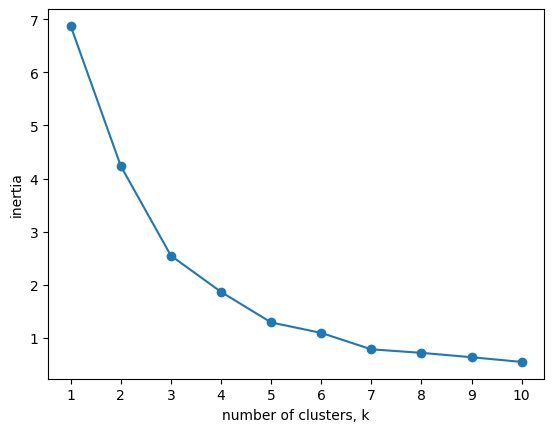

In [238]:
def plot_inertia(ks:list[int], kmeans_data):
    inertias = []
    for k in ks:
        model = KMeans(n_clusters=k)
        model.fit(X=kmeans_data)
        inertias.append(model.inertia_)
        
    plt.plot(ks, inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(ks)
    plt.show()

k_list = list(range(1,11))
plot_inertia(ks= k_list, kmeans_data=reduced_data)

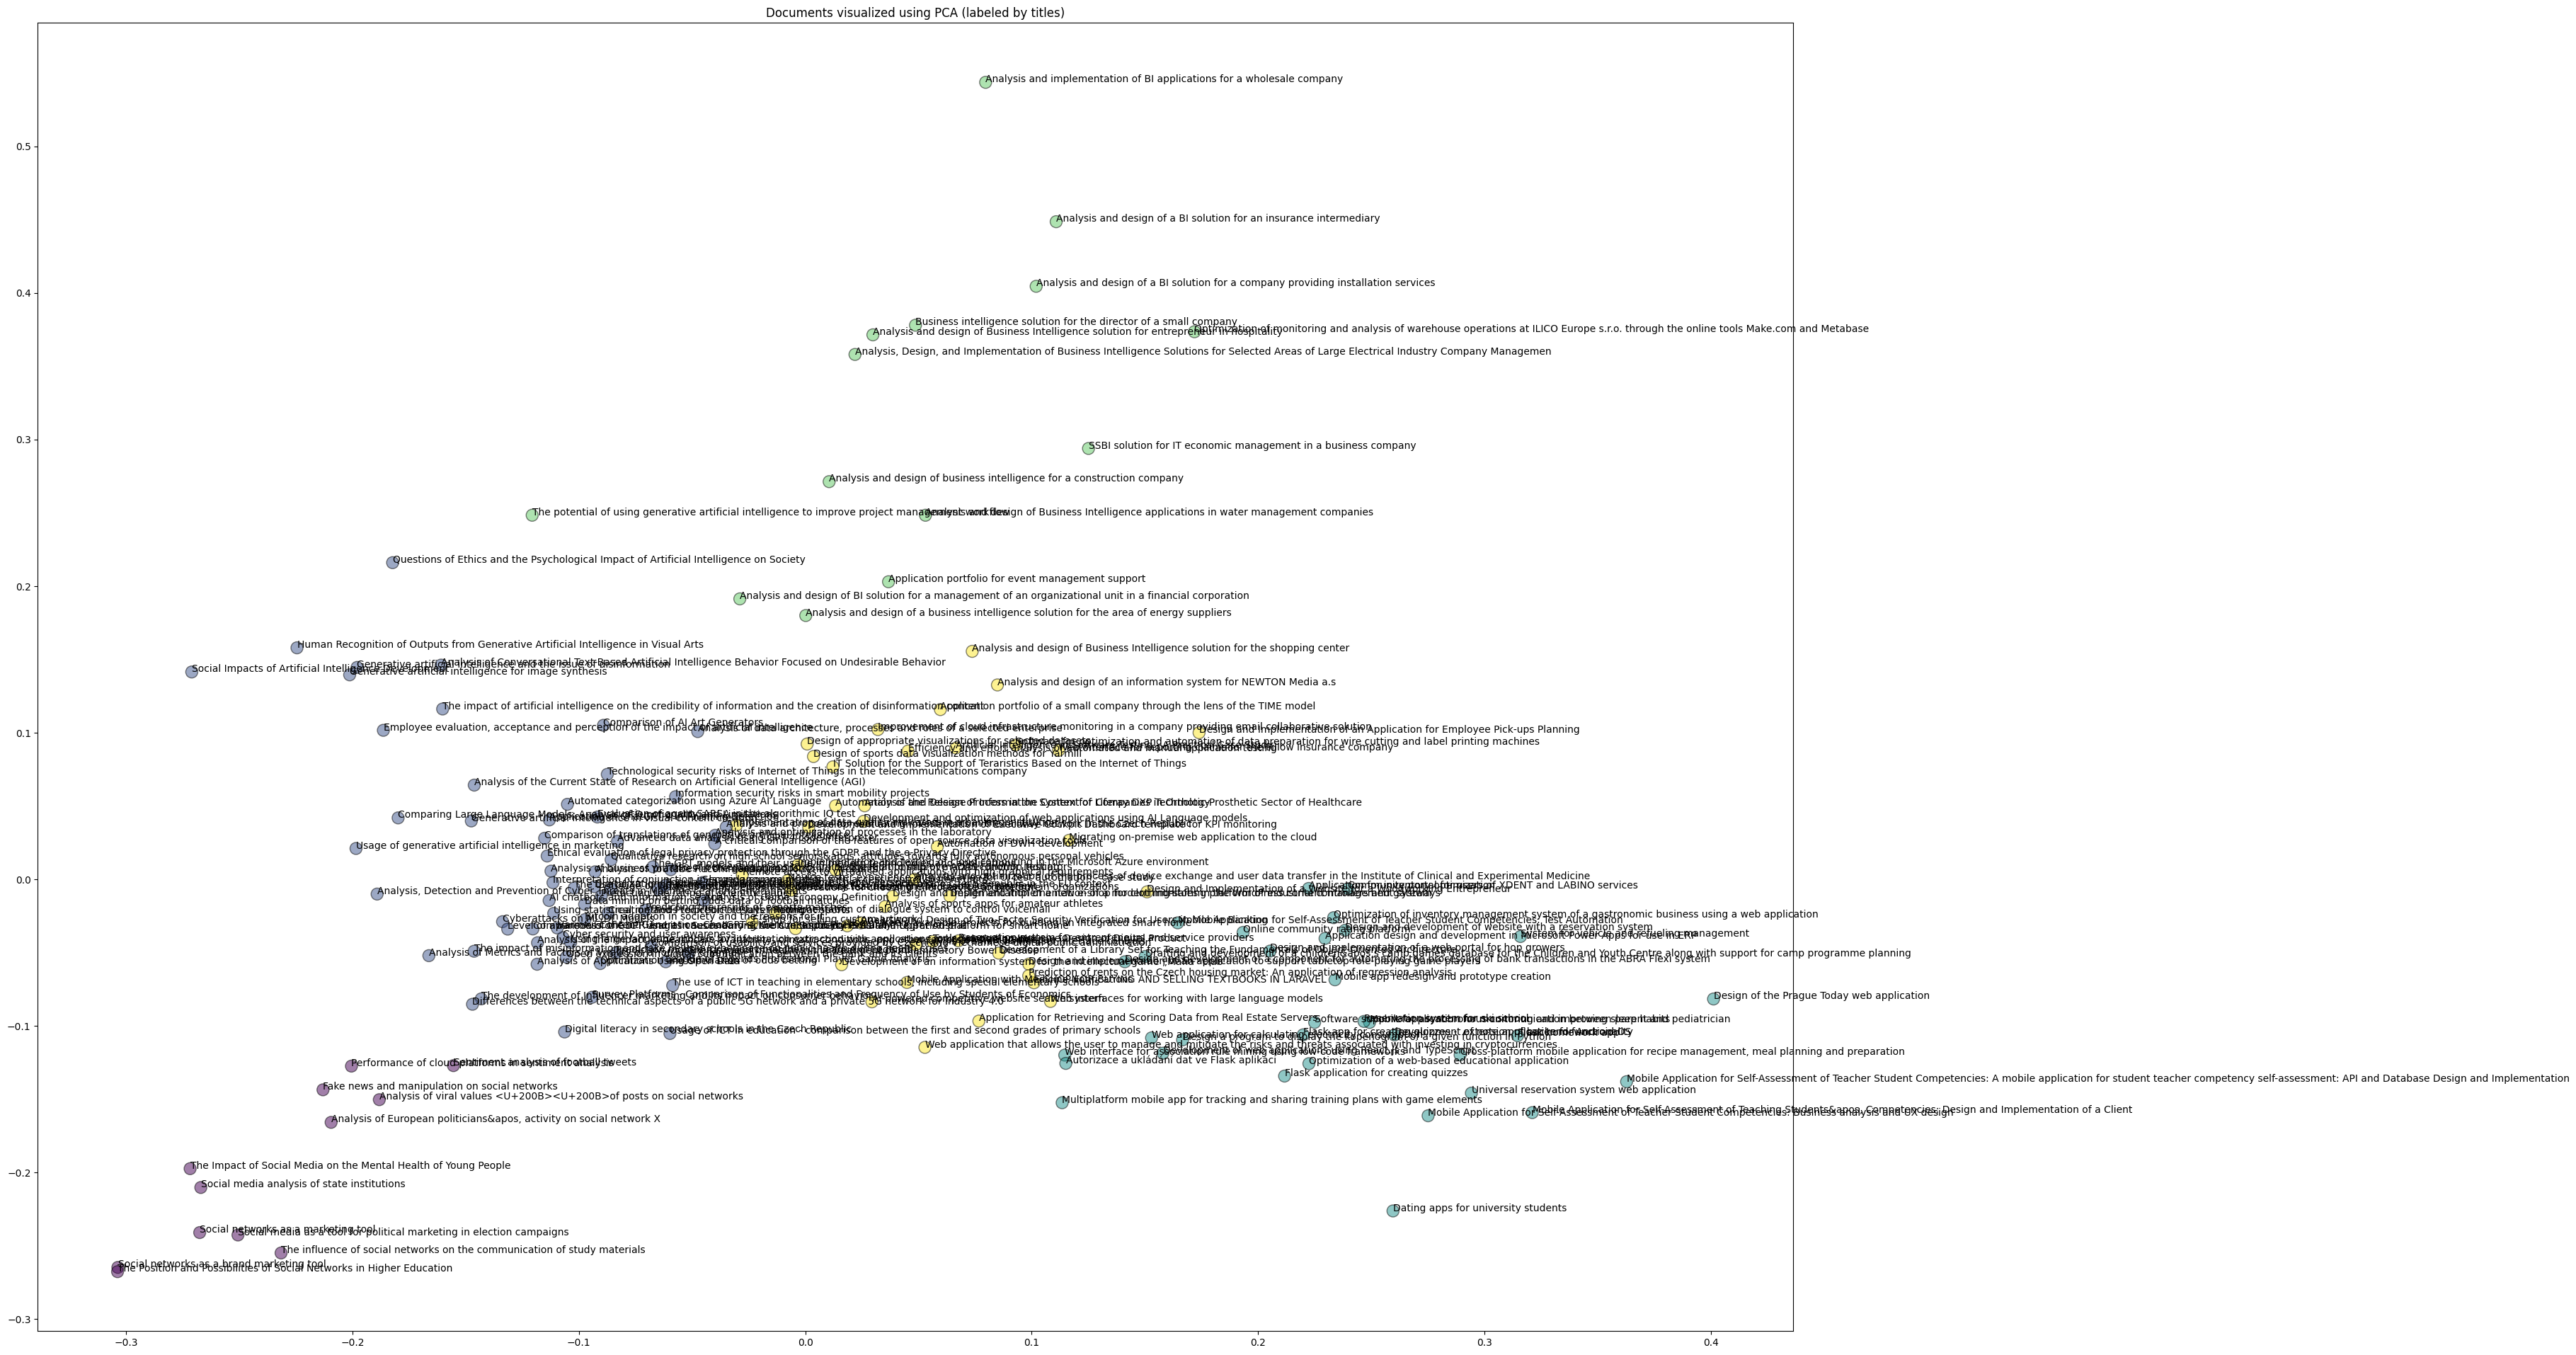

In [239]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(reduced_data)

plt.figure(figsize=(32, 24))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, edgecolors='k', s=150, alpha=0.5)
for i, filename in enumerate(names):
    plt.annotate(filename, (reduced_data[i, 0], reduced_data[i, 1]))
plt.title("Documents visualized using PCA (labeled by titles)")
plt.show()

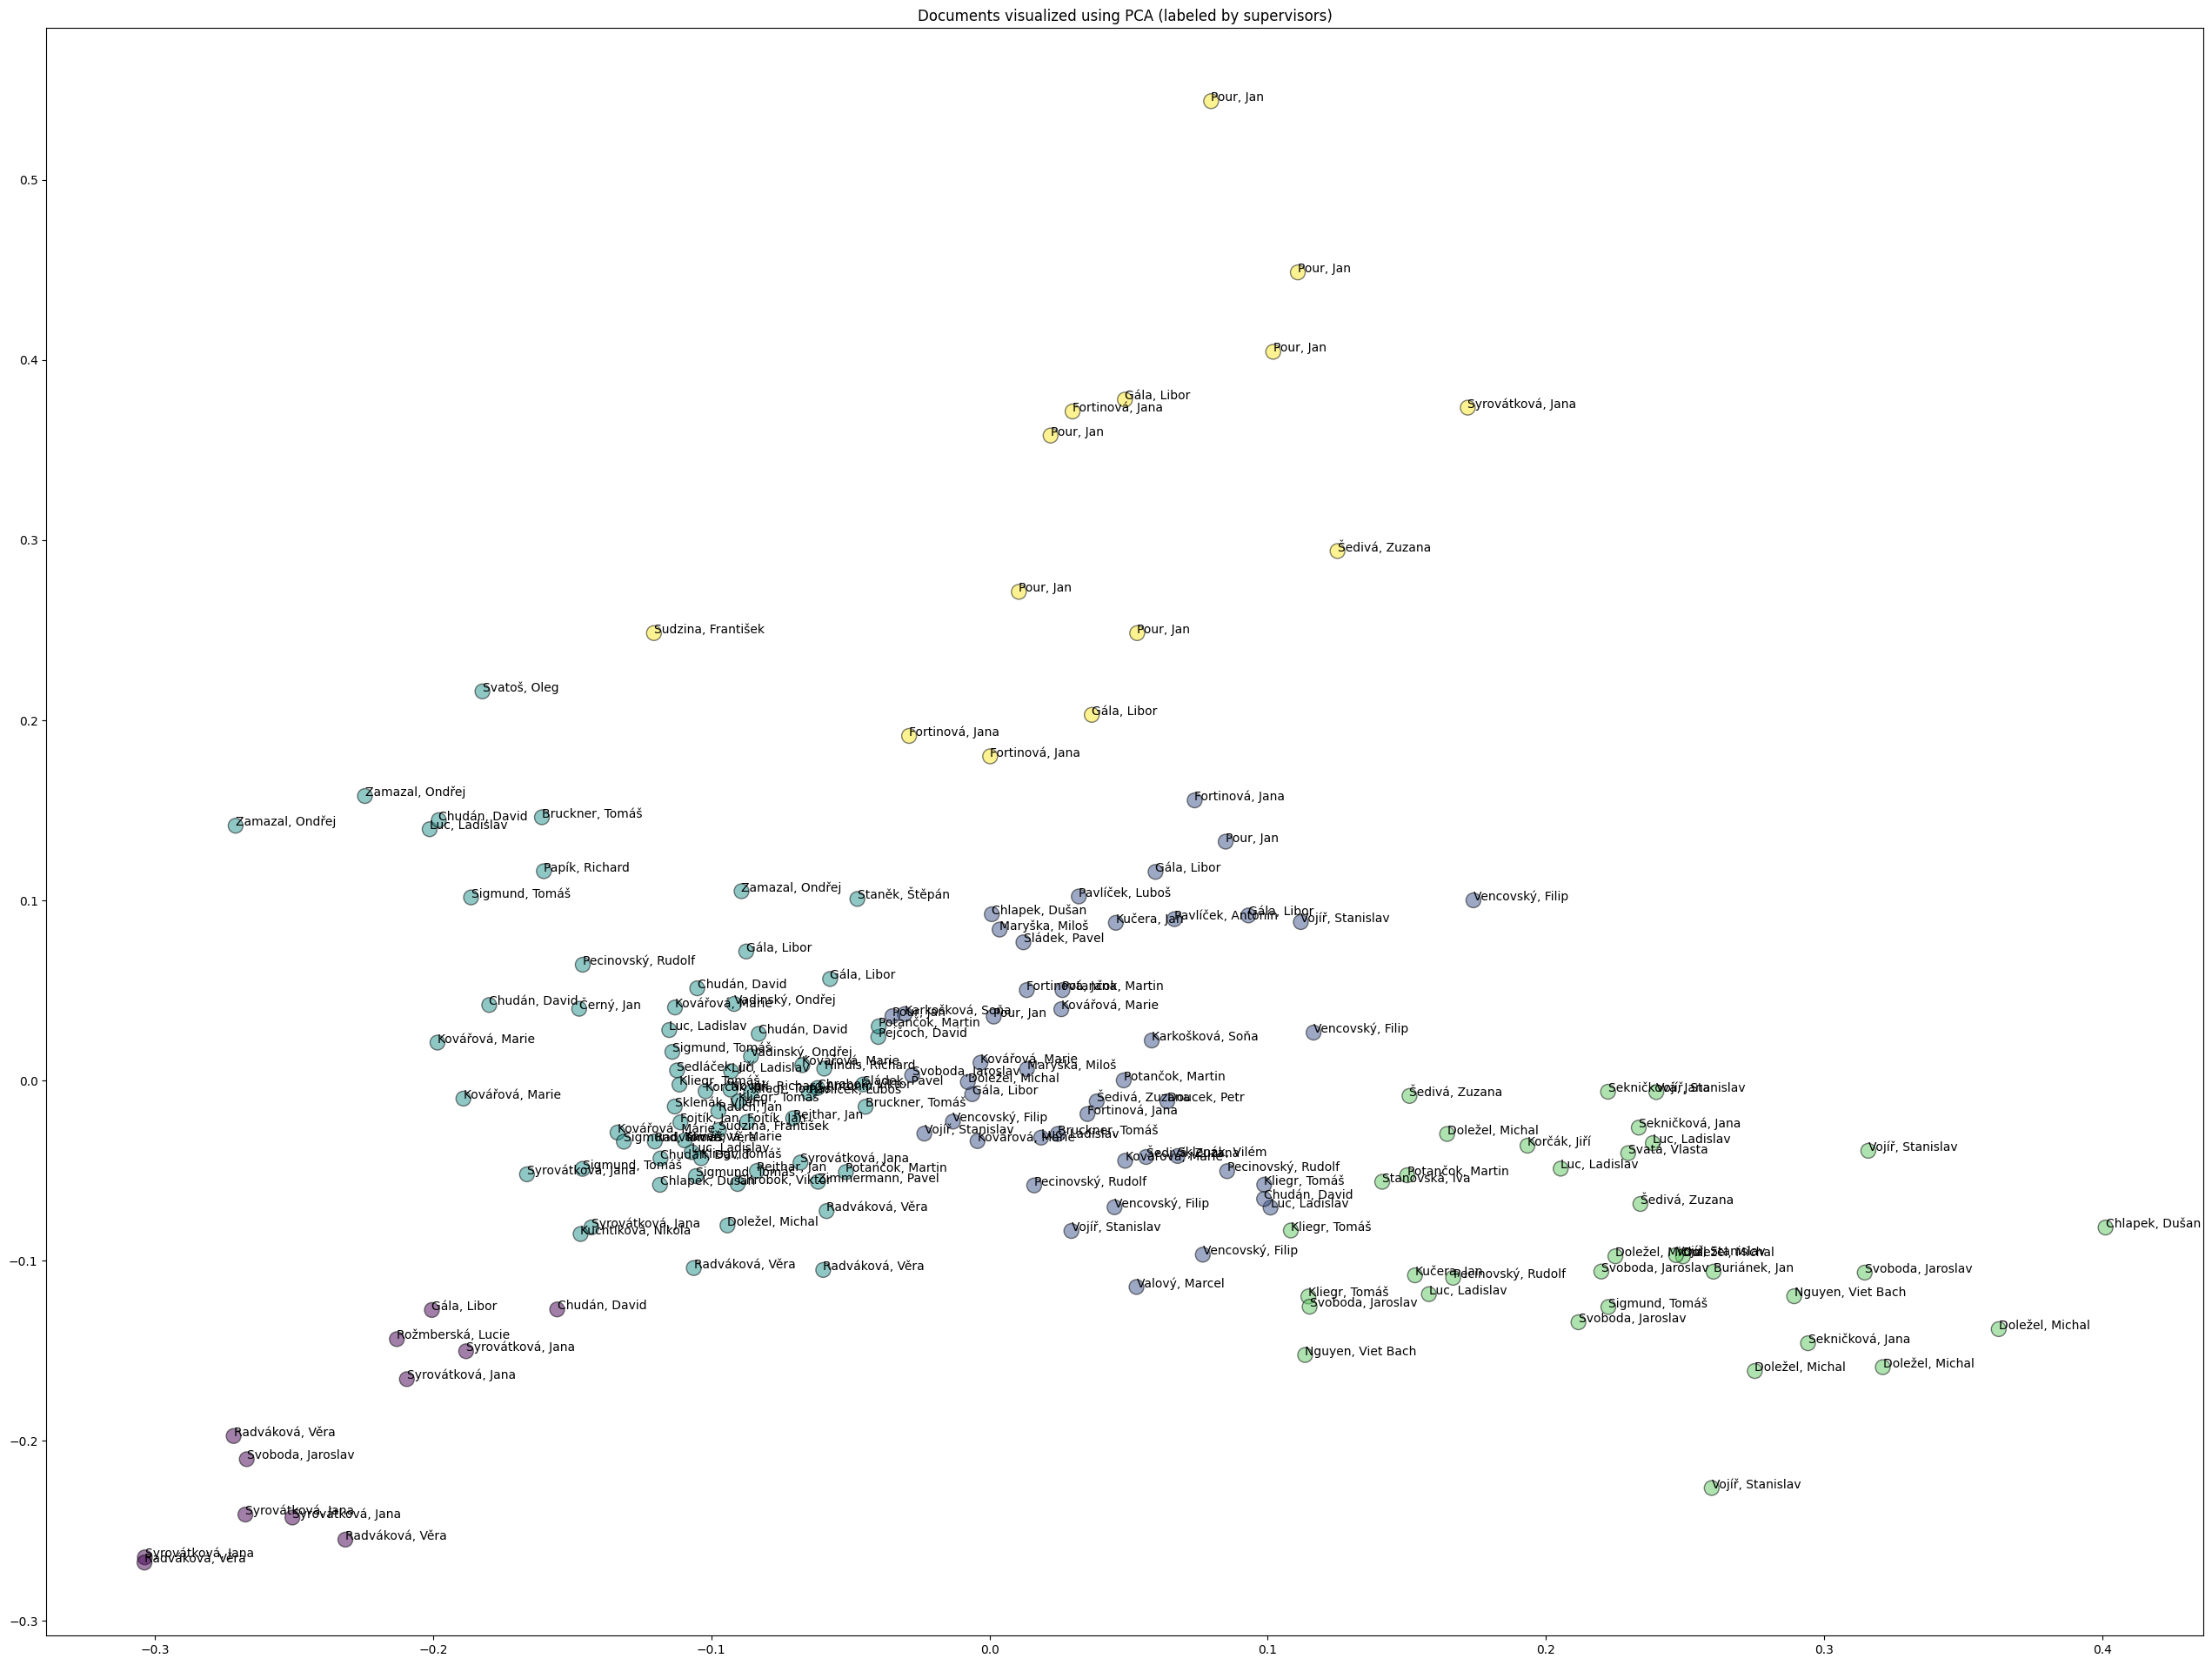

In [240]:
kmeans = KMeans(n_clusters=5)
clusters = kmeans.fit_predict(reduced_data)

plt.figure(figsize=(32, 24))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, edgecolors='k', s=150, alpha=0.5)
for i, filename in enumerate(supervisors):
    plt.annotate(filename, (reduced_data[i, 0], reduced_data[i, 1]))
plt.title("Documents visualized using PCA (labeled by supervisors)")
plt.show()


In my opinion, K-Means clustering makes more sense then hierarchical clustering. I chose 5 clusters based on the elbow method. The curve starts to level between 3 to 5 clusters, but dividing the theses into only 3 clusters does not give us much information.

In [241]:
df_fis["cluster"] = clusters

samples = df_fis.groupby('cluster', group_keys=False).apply(lambda x: x.sample(1))
samples[["cluster","titleEN","Supervisor", "KeywordsEN"]]

C:\Users\brzak\AppData\Local\Temp\ipykernel_7696\1034195660.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = df_fis.groupby('cluster', group_keys=False).apply(lambda x: x.sample(1))


,cluster,titleEN,Supervisor,KeywordsEN
42,0,Social media as a tool for political marketing...,"Syrovátková, Jana","social networks, political marketing, 2023 Slo..."
119,1,Analysis and Design of Information System for ...,"Potančok, Martin","information system design, orthotic-prosthetic..."
161,2,Comparison of the ICT Usage in Secondary Schoo...,"Radváková, Věra","school information system, ICT, secondary scho..."
167,3,Community portal for users of XDENT and LABINO...,"Vojíř, Stanislav","web application, XDENT, Vue.js, user support, ..."
49,4,Analysis and design of business intelligence f...,"Pour, Jan","self service business intelligence, SSBI, cons..."


Looking at the samples, there definitely are similarities, so I chose to explore the supervisors.


# Cluster Descriptions
The clusters (at least important part of them) should be described.

This section should contain:

Description of the selected approach
Examples of the descriptions obtained


In [242]:
supervisor_crosstab =pd.crosstab(df_fis['Supervisor'], df_fis['cluster'])
supervisor_crosstab["entropy"] = supervisor_crosstab.apply(lambda x: -np.sum((x / x.sum()) * np.log2(x / x.sum())), axis=1)
supervisor_crosstab

c:\Users\brzak\OneDrive\Desktop\School\4. semets\Textová analytika\text-analytics-1-coursework\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


cluster,0,1,2,3,4,entropy
Supervisor,,,,,,
"Bruckner, Tomáš",0,1,2,0,0,0.918296
"Buriánek, Jan",0,0,0,1,0,-0.000000
"Chlapek, Dušan",0,1,1,1,0,1.584963
"Chrobok, Viktor",0,0,2,0,0,-0.000000
"Chudán, David",1,1,5,0,0,1.148835
"Doležel, Michal",0,1,1,6,0,1.061278
"Doucek, Petr",0,1,0,0,0,-0.000000
"Fojtík, Jan",0,0,2,0,0,-0.000000
"Fortinová, Jana",0,3,0,0,3,1.000000


Text(0.5, 1.0, 'Entropy of clusters acrosss upervisors')

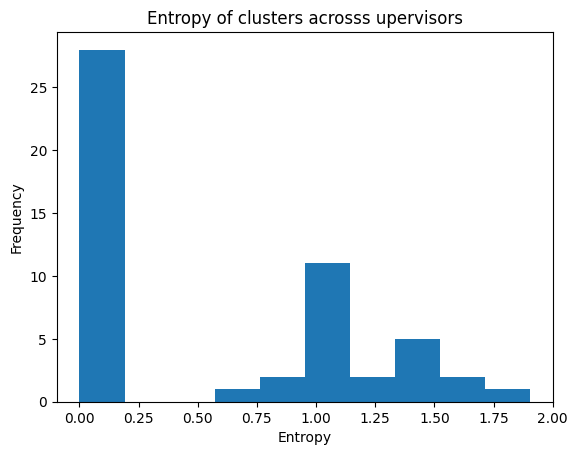

In [243]:
plt.hist(supervisor_crosstab['entropy'])
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.title('Entropy of clusters acrosss upervisors')

I cross tabulated the supervised theses of individual teachers across the clusters and computed entropy for each one (as seen on the histohram). In theory, each teacher should specialize in a different field, so they should be concentrated in a small number of clusters, instead of being evenly distributed across all clusters. The graph seems to confirm this theory, as the frequency of individuals decreases with higher entropy (ability of the set to suprise).

Looking at individual clusters, 

- Cluster 0: most ambiguous, frequent themes of software engineering 
- Cluster 1: AI, genAI
- Cluster 2: business intelligence
- Cluster 3: social networks, data literacy
- Cluster 4: development of applications, design


# Analytical Report


I think this is a good place to stop, as we have covered the basics of clustering and visualization of the data. I could further look into different methods, like UMAP or DBSCAN, however, I think my analysis came out pretty well. 

At some point in the process, I discovered my approach created a clusted further apart from the others and when checking it, I discovered that about 10 works are not correctly translated into English. I decided to drop these at the start of the script and not work with them anymore.

At the end, I used keywords of sampled theses to try to give meanings to individual clusters. Another approach could be to only classify based on keywords or keyword n-grams. As they are more specific, this may lead to more accurate results. I also toyed with the idea of webscraping the department names of individuals teachers and split them into groups based on the department. It would be very interesting to check for correlation between our clustering and supervisors' departments.